In [1]:
import shutil
import time
from pathlib import Path
from typing import Any
from typing import Dict

import attr
import numpy as np
from matplotlib import pyplot as plt

from common.log_utils import enable_debug_logging
from datagen.env_helper import create_env
from datagen.env_helper import create_vr_benchmark_config
from datagen.env_helper import display_video
from datagen.env_helper import get_null_vr_action
from datagen.godot_env import VRActionType
from datagen.world_creation.constants import AvalonTask
from datagen.world_creation.heightmap import DebugVisualizationConfig
from datagen.world_creation.heightmap import get_agent_export_config
from datagen.world_creation.heightmap import get_oculus_export_config
from datagen.world_creation.world_generator import _GENERATION_FUNCTION_BY_TASK

enable_debug_logging()

In [2]:

task = AvalonTask.MOVE
difficulty = 0.6
world_seed = 0
NUM_ACTIONS = 5
RESOLUTION = 96

env_seed = 0
video_id = 0


def create_world(output_path: Path, task: AvalonTask, difficulty: float, seed: int) -> Dict[str, Any]:
    start_time = time.time()
    rand = np.random.default_rng(seed)
    export_config = get_agent_export_config()
    generation_function = _GENERATION_FUNCTION_BY_TASK[task]
    world_path = output_path / f"{task.value}__{seed}__{difficulty}"
    generation_function(rand, difficulty, world_path, export_config)
    end_time = time.time()
    total_time = end_time - start_time
    return dict(task=task, difficulty=difficulty, world_path=world_path, time=total_time)


base_output_path = Path("/tmp/levels/debug/")
if base_output_path.exists():
    shutil.rmtree(base_output_path)
base_output_path.mkdir(parents=True, exist_ok=True)

result = create_world(base_output_path, task, difficulty, world_seed)

config = create_vr_benchmark_config()

with config.mutable_clone() as config:
    config.recording_options.resolution_x = RESOLUTION
    config.recording_options.resolution_y = RESOLUTION

action_type = VRActionType
env = create_env(config, action_type)

observations = [
    env.reset_nicely_with_specific_world(
        seed=env_seed,
        world_id=video_id,
        world_path=str(result["world_path"] / "main.tscn"),
    )
]

for i in range(NUM_ACTIONS):
    null_action = get_null_vr_action()
    obs, _ = env.act(null_action)
    observations.append(obs)

Worker (PID=645):  process group: /opt/projects/avalon/datagen/godot/datagen.sh --thread_count=4 -U --input_pipe_path=/mnt/private/tmp/ff2fb7a3-b1e1-4ff2-85c3-6a6eaea33f10/godot.log.actions --output_pipe_path=/mnt/private/tmp/ff2fb7a3-b1e1-4ff2-85c3-6a6eaea33f10/godot.log.observations --cuda-gpu-id=0 /mnt/private/data/interactive/2df488c4-3927-438c-97b3-81cfba8438fd/config.json' &>> /mnt/private/tmp/ff2fb7a3-b1e1-4ff2-85c3-6a6eaea33f10/godot.log
Worker (PID=645):  TO DEBUG RUN: /opt/projects/avalon/datagen/godot/datagen.sh --thread_count=4 -U --input_pipe_path=/mnt/private/data/interactive/2df488c4-3927-438c-97b3-81cfba8438fd/actions.out --output_pipe_path=/tmp/debug_output --cuda-gpu-id=0 /mnt/private/data/interactive/2df488c4-3927-438c-97b3-81cfba8438fd/config.json


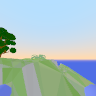

In [3]:
# display the video
display_video(observations, size=(RESOLUTION, RESOLUTION))

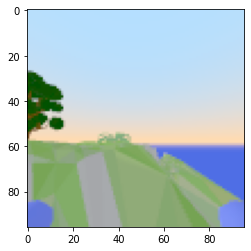

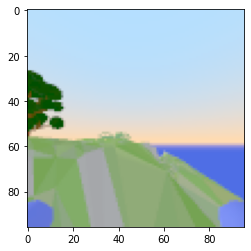

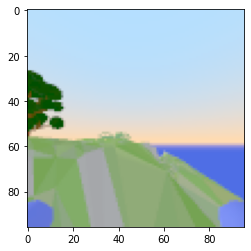

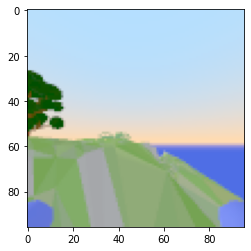

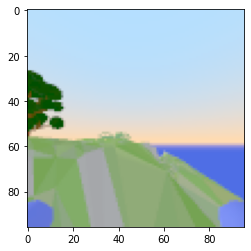

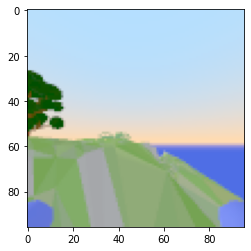

In [4]:
# display the first few frames as images
for obs in observations:
    plt.imshow(obs.rgbd[:,:,:3][::-1])
    plt.show()